In [1]:
import numpy as np
import pickle as pk
    
test_data_path = "test_data.pk"
pred_path = "X_pred.pk"

In [2]:
X_pred = pk.load(open(pred_path, "rb"))
X_pred[0].shape

2023-12-18 10:38:55.819148: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([11, 92])

In [3]:
import pickle as pk

test_data = pk.load(open(test_data_path, "rb"))
X_test = test_data["X"][:len(X_pred)]
X_test_oh = test_data["X_oh"][:len(X_pred)]
alphabet_size = test_data["alphabet_size"]

y_test = test_data["y"][:len(X_pred)]
event_mapping = test_data["event_mapping"]

len(X_test), len(y_test), np.unique(y_test, return_counts=True)

(15001, 15001, (array([0, 1]), array([7992, 7009])))

In [4]:
print(event_mapping)

{'24': 0, '40': 1, '61': 2, '72': 3, '41': 4, '75': 5, '69': 6, '39': 7, '83': 8, '74': 9, '109': 10, '27': 11, '105': 12, '34': 13, '111': 14, '98': 15, '85': 16, '87': 17, '116': 18, '108': 19, '101': 20, '63': 21, '<EOS>': 22, '62': 23, '42': 24, '96': 25, '86': 26, '57': 27, '95': 28, '58': 29, '13': 30, '21': 31, '112': 32, '80': 33, '32': 34, '45': 35, '118': 36, '36': 37, '30': 38, '104': 39, '51': 40, '102': 41, '64': 42, '53': 43, '89': 44, '50': 45, '17': 46, '47': 47, '28': 48, '106': 49, '29': 50, '73': 51, '46': 52, '120': 53, '16': 54, '82': 55, '67': 56, '54': 57, '107': 58, '76': 59, '60': 60, '49': 61, '84': 62, '100': 63, '14': 64, '119': 65, '12': 66, '68': 67, '78': 68, '52': 69, '91': 70, '23': 71, '90': 72, '18': 73, '35': 74, '117': 75, '115': 76, '20': 77, '25': 78, '<SOS>': 79, '56': 80, '130': 81, '93': 82, '94': 83, '79': 84, '65': 85, '113': 86, '43': 87, '97': 88, '38': 89, '71': 90, '19': 91}


In [5]:
#top_k = 3
#y_pred_top_k = list()
probabilities = list()
for pred_seq, true_seq in zip(X_pred, X_test_oh):
    current_probs = list()
    for p_oh, t_oh in zip(pred_seq, true_seq): 
        #pred_partion = np.argpartition(pred_seq, len(pred_seq) - top_k)[-top_k:]
        true_next_symbol = np.argmax(t_oh)
        true_next_symbol_p = np.max(t_oh)
        pred_next_symbol_p = p_oh[true_next_symbol]
        current_probs.append(abs(true_next_symbol_p - pred_next_symbol_p))
    probabilities.append(current_probs)
print(len(probabilities))

15001


In [6]:
current_labels = y_test[:len(probabilities)]
len(current_labels)

15001

In [7]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([7992, 7009]))

In [8]:
# mean, min
mean_score = list()
min_score = list()
max_score = list()
sum_score = list()
for p in probabilities:
    p = np.array(p)
    mean_score.append(np.mean(p))
    min_score.append(np.min(p))
    max_score.append(np.max(p))
    sum_score.append(np.sum(p))

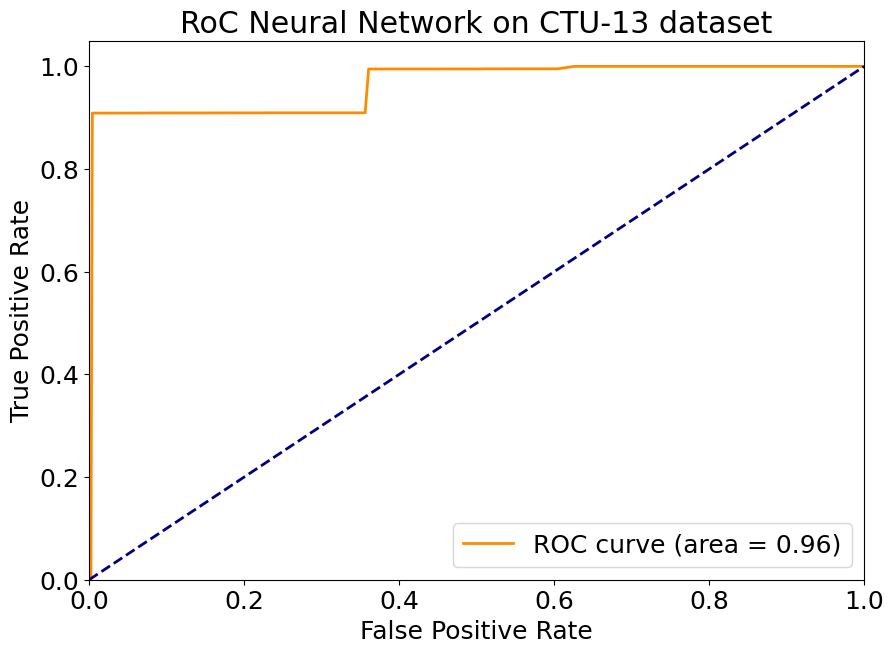

In [19]:
import matplotlib

matplotlib.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_curve, auc, roc_auc_score

score = max_score

fpr, tpr, thresholds = roc_curve(current_labels, score)
roc_auc = roc_auc_score(current_labels, score)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RoC Neural Network on CTU-13 dataset")
plt.legend(loc="lower right")

plt.savefig("roc_network_ctu.png")

<Figure size 640x480 with 0 Axes>

In [11]:
top_k = 10
y_pred_top_k = list()

for pred_seq, true_seq in zip(X_pred, X_test_oh):
    is_anomaly = False
    for j, (p_oh, t_oh) in enumerate(zip(pred_seq, true_seq)):
        if j==len(p_oh)-1:
            break
        pred_partition = np.argpartition(p_oh, len(p_oh) - top_k)[-top_k:]
        
        true_next_symbol = np.argmax(t_oh)
        if not true_next_symbol in set(list(pred_partition)):
            is_anomaly = True
    y_pred_top_k.append(1 if is_anomaly else 0)
print(y_pred_top_k[:5]), len(y_pred_top_k), len(X_pred), np.unique(y_pred_top_k, return_counts=True)

[0, 1, 1, 1, 1]


(None, 15001, 15001, (array([0, 1]), array([ 2457, 12544])))

In [12]:
y_test[:5]

[0, 1, 1, 1, 0]

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[:len(y_pred_top_k)], y_pred_top_k)

0.6310245983601094